## Initial Setup

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
import pandas_profiling
from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


## Loading the Dataset

In [ ]:

df = pd.read_csv("/content/Arctic_domain_mean_monthly_1979_2021.csv")
# remove date from the set
df = df.drop('Date', 1)
df.loc[:, 'sea_ice_extent_2'] = df['sea_ice_extent']
df.head()


<ipython-input-2-a806c5377ae6>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Date', 1)


,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent,sea_ice_extent_2
0,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191,15604191
1,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929,16378929
2,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089,16521089
3,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238,15561238
4,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613,14085613


In [ ]:
#Creating datasets with lag of 1 month
df1 = df.assign(sea_ice_extent_2 = df.sea_ice_extent_2.shift(-1)).drop(df.index[-1])

In [ ]:
df1.head

<bound method NDFrame.head of      wind_10m  specific_humidity     LW_down     SW_down  rainfall  snowfall  \
0    5.531398           0.811961  186.687054    3.127880  1.009872  0.892319   
1    5.328020           0.688896  174.794571   18.541594  0.920831  0.781347   
2    5.432511           0.916124  190.741933   67.690429  0.983327  0.855266   
3    4.792836           1.272056  212.937925  156.223673  0.890723  0.705203   
4    4.819028           2.239776  253.690478  230.950833  1.201308  0.688723   
..        ...                ...         ...         ...       ...       ...   
506  5.494218           1.006108  194.683072   68.315949  1.135685  0.919100   
507  5.383687           1.529497  225.171796  156.567743  1.159049  0.929777   
508  4.777020           2.451088  260.956781  229.604138  1.077705  0.575494   
509  4.771453           4.176458  294.931709  244.702852  1.585094  0.360146   
510  4.754014           5.193846  313.311345  196.774631  1.957911  0.248088   

         

## Train Test Split

In [ ]:
data = np.array(df1)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

# print(data.shape)
# print(target.shape)
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing


x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]



In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(481, 10)
(481,)
(30, 10)
(30,)


## Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train) 
x_test = scaler_x.transform(x_test) 

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1)) 

## Defining Model

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

## Model Predictions

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

In [ ]:
#Sample code to inverse transform data
#Inverse transformation should be performed after getting predictions
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


## Plotting Results

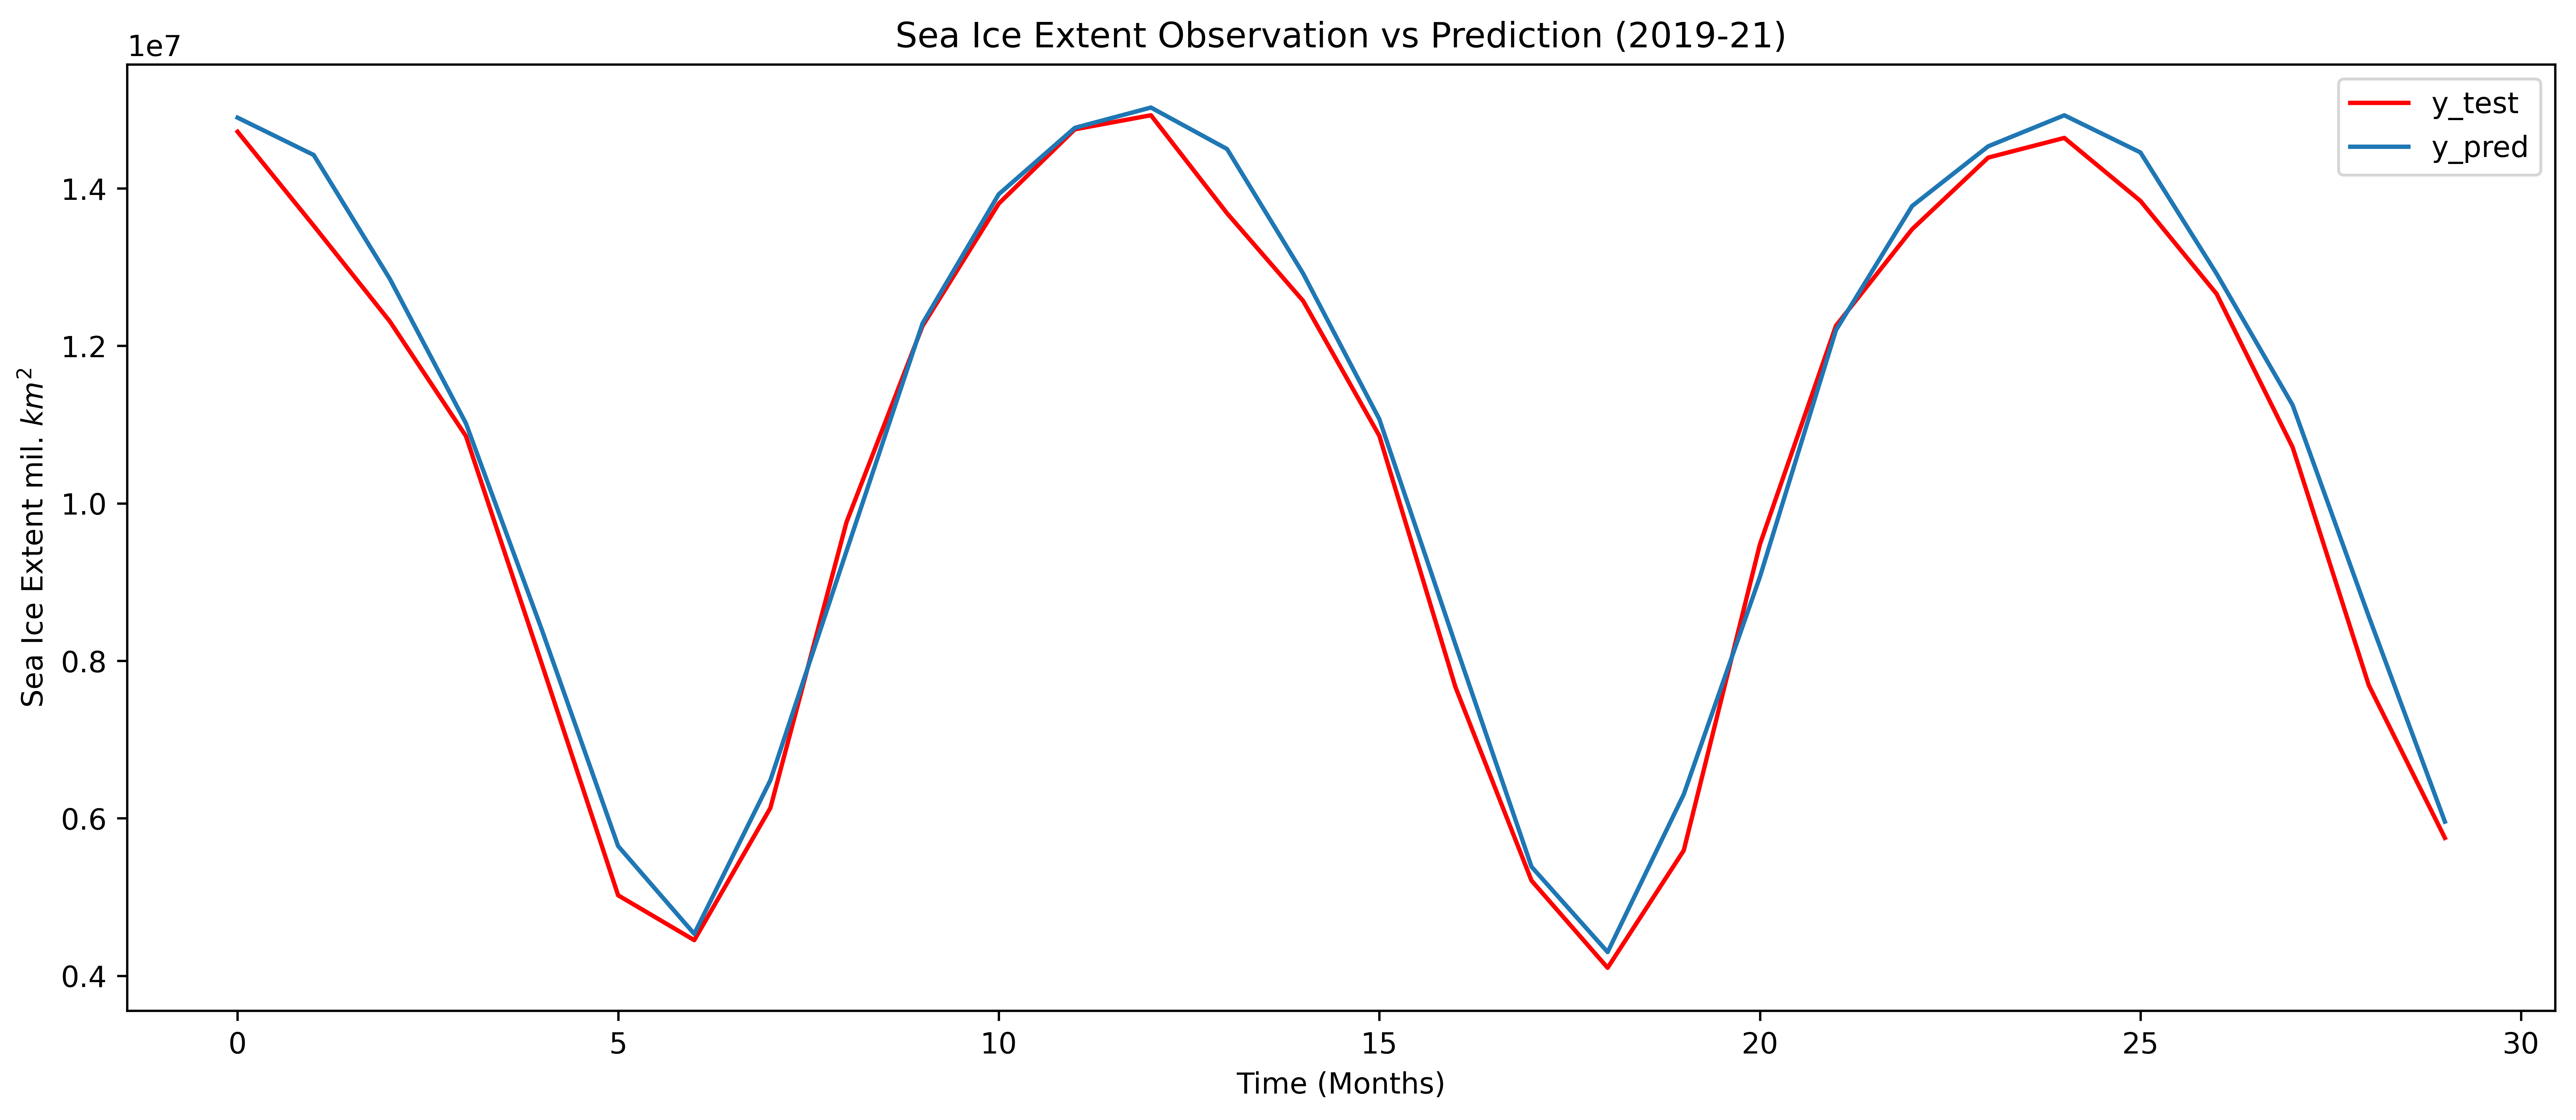

In [ ]:
%matplotlib inline
#plot 
fig, ax= plt.subplots(figsize=(15, 6), dpi = 600)
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)

plt.legend(['y_test','y_pred'])
plt.title("Sea Ice Extent Observation vs Prediction (2019-21)")
ax.set_xlabel("Time (Months)")
ax.set_ylabel(r"Sea Ice Extent mil. $km^2$")
plt.show()
fig.savefig('Time_series_sea_ice_extent_trend_1979_2021_lag1.png')

## Performance Evaluation

In [ ]:
rmse1 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
print('Test RMSE: %0.2f Mil. sq Km' %(rmse1))

Test RMSE: 433143.27 Mil. sq Km


In [ ]:
nrmse1 = rmse1/(np.mean(inv_y_test))
nrmse1

0.04124839984143858

In [ ]:
r2 = r2_score(inv_y_test, inv_y_pred)
print('R2 Score: %0.2f' %(r2))

R2 Score: 0.99
